In [31]:
# Importations
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch

# Graine aléatoire pour reproductibilité
np.random.seed(42)
torch.manual_seed(42)
print("Bibliothèques chargées avec succès !")

Bibliothèques chargées avec succès !


In [32]:
# Load files
train_edges = pd.read_csv(
    "data/train.txt", sep=" ", header=None, names=["node1", "node2", "label"]
)
test_pairs = pd.read_csv(
    "data/test.txt", sep=" ", header=None, names=["node1", "node2"]
)
node_features = pd.read_csv("data/node_information.csv", header=None)
sample_submission = pd.read_csv("data/random_predictions.csv")

# Preview the data
print("Preview of node_information.csv:")
display(node_features.head())

print("\nPreview of train.txt:")
display(train_edges.head())

print("\nPreview of test.txt:")
display(test_pairs.head())

# Build the graph
G = nx.from_pandas_edgelist(train_edges, "node1", "node2")

# Assume first column is the node identifier
id_column = node_features.columns[0]  # Adjust if needed after inspection
feature_cols = [col for col in node_features.columns if col != id_column]
X = torch.tensor(node_features[feature_cols].values, dtype=torch.float)
node_id_map = {id: idx for idx, id in enumerate(node_features[id_column])}

# Ensure consistent node types and mapping
train_edges["node1"] = train_edges["node1"].astype(int)
train_edges["node2"] = train_edges["node2"].astype(int)
node_features[id_column] = node_features[id_column].astype(int)

# Create mapping to ensure all nodes are covered
node_id_map = {id: idx for idx, id in enumerate(node_features[id_column])}

# Check unmapped nodes
train_nodes = set(train_edges["node1"]).union(set(train_edges["node2"]))
mapped_nodes = set(node_id_map.keys())
unmapped_nodes = train_nodes - mapped_nodes

print("Unmapped nodes:", unmapped_nodes)

# Basic node statistics
node_ids = set(node_id_map.keys())
print(f"\nNodes in train.txt: {len(train_nodes)}" + "\n" + "-" * 25)
print(f"Nodes in node_information.csv: {len(node_ids)}" + "\n" + "-" * 25)
print(f"Common nodes: {len(train_nodes.intersection(node_ids))}" + "\n" + "-" * 25)

# Graph info
print(f"\nNumber of nodes in the graph: {G.number_of_nodes()}" + "\n" + "-" * 25)
print(f"Number of edges in train set: {G.number_of_edges()}" + "\n" + "-" * 25)
print(f"Number of pairs to predict: {len(test_pairs)}" + "\n" + "-" * 25)
print(f"Feature dimension: {X.shape[1]}" + "\n" + "-" * 25)
print(f"ID column used: {id_column}" + "\n" + "-" * 25)

Preview of node_information.csv:


,0,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Preview of train.txt:


,node1,node2,label
0,939,3809,1
1,2442,5784,1
2,179,3809,1
3,857,2280,1
4,1358,5722,1



Preview of test.txt:


,node1,node2
0,3425,4524
1,1620,2617
2,4832,6317
3,4984,7298
4,385,5481


Unmapped nodes: set()

Nodes in train.txt: 3597
-------------------------
Nodes in node_information.csv: 3597
-------------------------
Common nodes: 3597
-------------------------

Number of nodes in the graph: 3597
-------------------------
Number of edges in train set: 10496
-------------------------
Number of pairs to predict: 3498
-------------------------
Feature dimension: 932
-------------------------
ID column used: 0
-------------------------


In [33]:
non_zero_counts = (node_features.drop(columns=[id_column]) != 0).sum()
print(f"Features non-nulles : {(non_zero_counts > 0).sum()} / {len(non_zero_counts)}")

Features non-nulles : 929 / 932


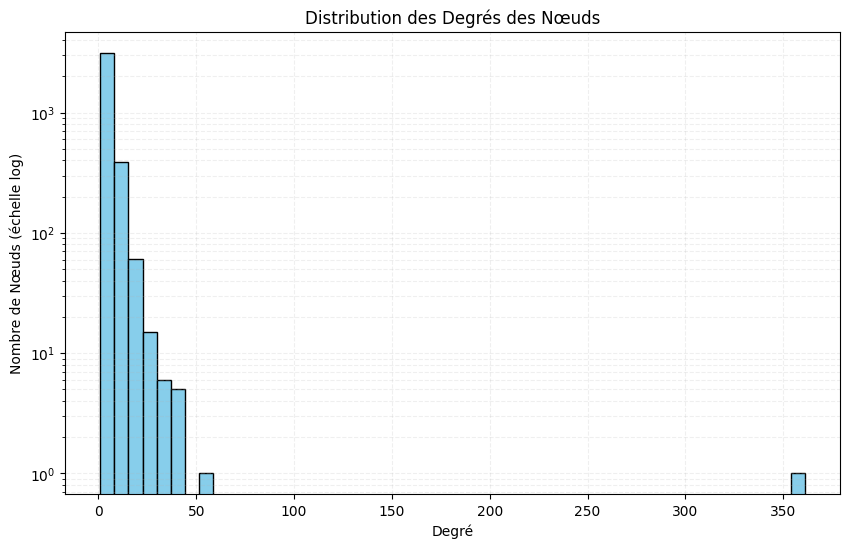

Cette visualisation montre la répartition des degrés, utile pour identifier les hubs.


In [34]:
# Calcul des degrés
degrees = [d for n, d in G.degree()]

# Histogramme des degrés
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50, log=True, color="skyblue", edgecolor="black")
plt.title("Distribution des Degrés des Nœuds")
plt.xlabel("Degré")
plt.ylabel("Nombre de Nœuds (échelle log)")
plt.grid(True, which="both", ls="--", alpha=0.2)
plt.show()

print(
    "Cette visualisation montre la répartition des degrés, utile pour identifier les hubs."
)

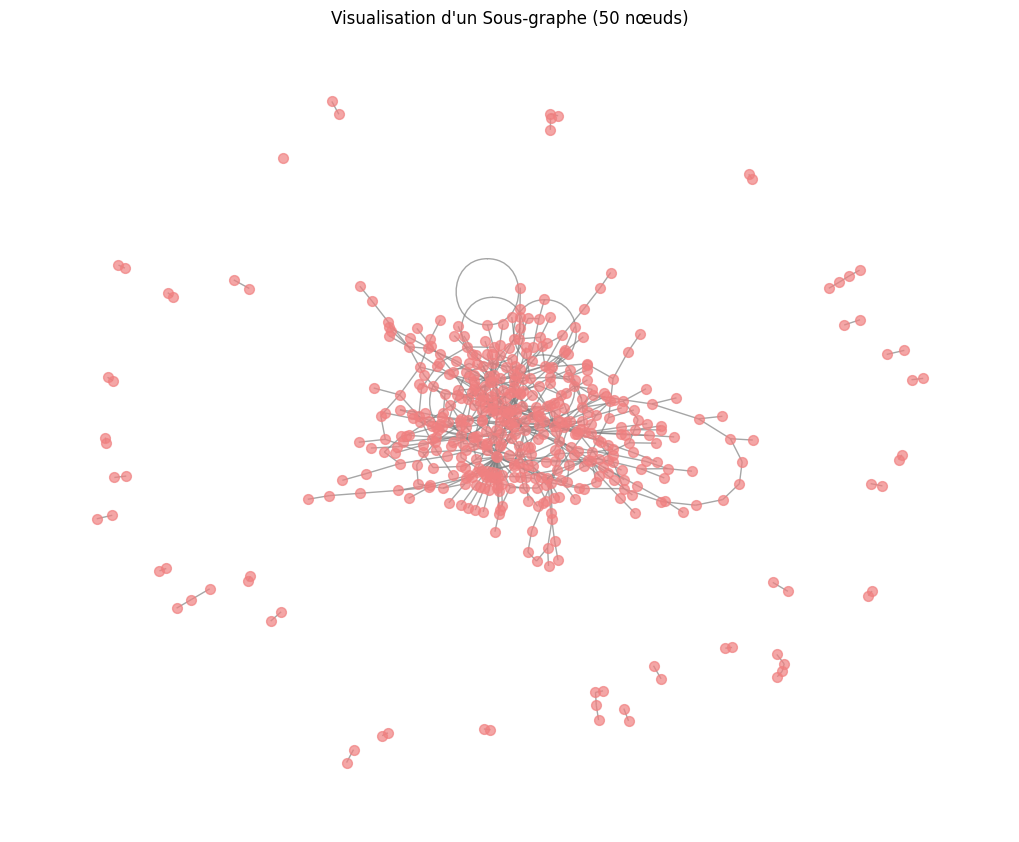

Ce sous-graphe donne un aperçu de la structure locale du réseau.


In [38]:
# Extraction d'un petit sous-graphe (50 premiers nœuds)
subgraph_nodes = list(G.nodes())[:500]
subG = G.subgraph(subgraph_nodes)

# Dessin du sous-graphe
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(
    subG,
    pos,
    node_size=50,
    node_color="lightcoral",
    with_labels=False,
    edge_color="gray",
    alpha=0.7,
)
plt.title("Visualisation d'un Sous-graphe (50 nœuds)")
plt.show()

print("Ce sous-graphe donne un aperçu de la structure locale du réseau.")

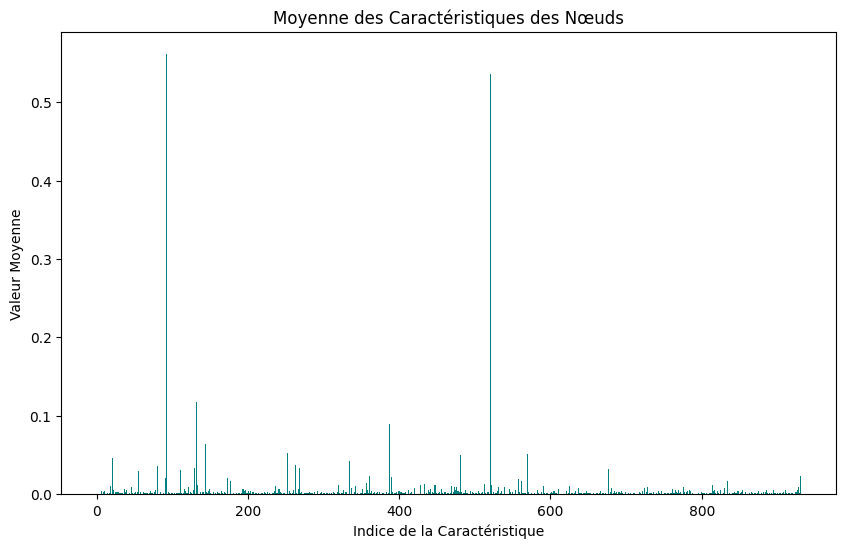

Cet histogramme montre la distribution des valeurs moyennes des caractéristiques.


In [39]:
# Moyenne des caractéristiques par nœud
mean_features = X.mean(dim=0).numpy()

# Histogramme
plt.figure(figsize=(10, 6))
plt.bar(range(len(mean_features)), mean_features, color="teal")
plt.title("Moyenne des Caractéristiques des Nœuds")
plt.xlabel("Indice de la Caractéristique")
plt.ylabel("Valeur Moyenne")
plt.show()

print(
    "Cet histogramme montre la distribution des valeurs moyennes des caractéristiques."
)

In [ ]:
# Fonction pour calculer l'indice Adamic-Adar
def compute_adamic_adar(G, pairs):
    preds = []
    for u, v in pairs:
        if u in G and v in G:
            score = sum(
                1 / np.log(G.degree(w))
                for w in nx.common_neighbors(G, u, v)
                if G.degree(w) > 1
            )
            preds.append(score if score > 0 else 0)
        else:
            preds.append(0)
    return preds


# Prédictions baseline pour les paires de test
test_node_pairs = test_pairs[["node1", "node2"]].values
adamic_adar = compute_adamic_adar(G, test_node_pairs)
baseline_preds = np.array(adamic_adar) / (np.max(adamic_adar) + 1e-10)  # Normalisation
print("Prédictions baseline calculées.")

Prédictions baseline calculées.


In [43]:
# Check node_id_map
print("node_id_map contents:")
print(node_id_map)
print("Number of nodes in node_id_map:", len(node_id_map))

# Check original graph
print("Total number of edges in original graph:", len(G.edges()))
print("Total number of nodes in original graph:", len(G.nodes()))

# Verify edge mapping
print("Sample edges:")
for u, v in list(G.edges())[:5]:
    print(f"Edge: {u} - {v}")
    print(
        f"Mapped nodes: {node_id_map.get(u, 'Not found')} - {node_id_map.get(v, 'Not found')}"
    )

node_id_map contents:
{0: 0, 4: 1, 5: 2, 6: 3, 7: 4, 9: 5, 10: 6, 11: 7, 13: 8, 17: 9, 19: 10, 20: 11, 23: 12, 24: 13, 25: 14, 26: 15, 27: 16, 28: 17, 30: 18, 32: 19, 33: 20, 36: 21, 37: 22, 38: 23, 39: 24, 40: 25, 46: 26, 49: 27, 51: 28, 52: 29, 53: 30, 55: 31, 60: 32, 61: 33, 62: 34, 64: 35, 67: 36, 69: 37, 70: 38, 72: 39, 74: 40, 75: 41, 79: 42, 80: 43, 81: 44, 84: 45, 86: 46, 87: 47, 88: 48, 89: 49, 90: 50, 92: 51, 93: 52, 94: 53, 96: 54, 97: 55, 98: 56, 99: 57, 103: 58, 104: 59, 105: 60, 106: 61, 107: 62, 108: 63, 109: 64, 114: 65, 117: 66, 119: 67, 125: 68, 127: 69, 130: 70, 132: 71, 133: 72, 137: 73, 138: 74, 139: 75, 141: 76, 142: 77, 144: 78, 147: 79, 148: 80, 150: 81, 151: 82, 153: 83, 154: 84, 156: 85, 157: 86, 158: 87, 159: 88, 160: 89, 161: 90, 162: 91, 164: 92, 165: 93, 166: 94, 171: 95, 173: 96, 174: 97, 175: 98, 178: 99, 179: 100, 180: 101, 182: 102, 184: 103, 185: 104, 186: 105, 187: 106, 188: 107, 189: 108, 190: 109, 191: 110, 195: 111, 196: 112, 197: 113, 202: 114, 2